# Optimizing Softmax Regression with MCMC

In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import emcee
import corner

## Softmax Regression

In [2]:
def softmax(z):                                        # define the softmax function
            z -= np.max(z)                             # for numerical stability
            return (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    
def one_hot(y, C):                                     # define the one-hot encoding for labels
            return (np.arange(C) == y[:, None]).astype(float)

class SoftmaxRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
    
    def fit(self, x, y, optimizer):
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        C = np.max(y) + 1
        w0 = np.zeros((D, C))                               # initialize the weights to 0, note that the dimension is D*C
        
        # optimize using MCMC
        if isinstance(optimizer, BayesianInferenceMCMC):
            def log_likelihood(w_flat, x, y):
                w_og = w_flat.reshape(x.shape[1],np.max(y)+1) # reshape the flattened 1d parameter array into the origianl dimension
                yh = softmax(np.dot(x, w_og))               # predictions, i.e. the probabilities for each label class
                y = one_hot(y, C)                           # labels with one-hot encoding
                log_like = np.sum(y*np.log(yh))             # log corss-entropy likelihood
                # MCMC introduces random parameters, which can be very large
                # some large parameters may cause the softmax function to overflow and return nan
                # in fact these large parameters are definitely not good parameters for the model
                # so we treat these cases as zero likelihood, i.e. -infinity log likelihood
                if math.isnan(log_like):
                    return -np.inf
                return log_like
            def log_prior(w_flat):
                return 0.0                                  # no specific preference for the parameters
            def log_post(w_flat, x, y):
                return log_prior(w_flat) + log_likelihood(w_flat, x, y)
            self.w = optimizer.run(log_post, x, y, w0)      # run the optimizer to get the optimal weights
            
        # optimize using Gradient Descent
        if isinstance(optimizer, ImprovedGradientDescent):
            def gradient(x, y, w):                          # define the gradient function
                yh = softmax(np.dot(x, w))                  # predictions
                y = one_hot(y, C)                           # labels with one-hot encoding
                N, D = x.shape
                grad = np.dot(x.T, (yh - y))/N              # divide by N because cost is mean over N points
                return grad
            self.w = optimizer.run(gradient, x, y, w0)      # run the optimizer to get the optimal weights
            
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        yh = softmax(np.dot(x,self.w))                       #predict output
        return yh

In [3]:
# note that the output of the Softmax Regression is the probabilities for the label classes
# so we need to convert the output into the label classes with the highest probabilities for the classification purpose

def to_classlabel(z):                                   # convert the output class probabilities to be class labels
    return z.argmax(axis=1)

## Optimizer 1: Bayesian inference with MCMC

In [4]:
class BayesianInferenceMCMC:
    def __init__(self, visual_log_like=False, corner=False):
        self.visual_log_like = visual_log_like
        self.corner = corner
            
    def run(self, log_post, x, y, w):
        num_iter = 4000
        w_flat = w.reshape(-1) # reshape the parameter array into a 1d array that can be input of emcee
        ndim = len(w_flat)     # number of parameters
        nwalkers = 60
        initial_pos = w_flat + 0.01 * np.random.randn(nwalkers, ndim)
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x, y))
        sampler.run_mcmc(initial_pos, num_iter, progress=True)
        w_flat = np.median(sampler.get_chain(discard=2000, flat=True), axis=0)
        w = w_flat.reshape(x.shape[1],np.max(y) + 1) # reshape the optimized 1d parameter array into the origianl dimension
        
        # visualize the log-likelihood evolved with the MCMC steps if needed
        if self.visual_log_like == True:
            plt.plot(np.linspace(0,num_iter,num_iter), sampler.lnprobability.T)
            plt.title('log-likelihood v.s. steps')
            plt.xlabel("Steps")
            plt.ylabel("log-likelihood")
            plt.show()
        
        # plot the corner plot if needed
        if self.corner == True:
            flat_samples = sampler.get_chain(discard=2000, thin=15, flat=True)
            fig = corner.corner(flat_samples, quantiles=[0.05, 0.5, 0.95])
        
        return w

## Optimizer 2: Gradient Descent (for comparison)

In [5]:
def create_mini_batches(x, y, batch_size): 
    mini_batches = []
    data = np.hstack((x, y[:,None]))
    np.random.shuffle(data) 
    n_minibatches = math.ceil(data.shape[0] // batch_size) 
    data = np.array_split(data, n_minibatches)
    mini_batches = []
    for batch_data in data:
        x_mini = batch_data[:, :-1]
        y_mini = batch_data[:, -1]
        mini_batches.append((x_mini, y_mini))
    return mini_batches

class ImprovedGradientDescent:
    def __init__(self, learning_rate=0.1, max_iters=1e4, epsilon=1e-8, record_history=False, momentum=0.5, batch_size=20):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        self.momentum = momentum
        self.batch_size = batch_size
        if record_history:
            self.w_history = []                         #to store the weight history for visualization
            
    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        grad_old = 0
        t = 1
        accuracy = 0
        accuracy_best = 0
        num_worse = 0
        w_best = w
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            mini_batches = create_mini_batches(x, y, self.batch_size) 
            for mini_batch in mini_batches: 
                x_mini, y_mini = mini_batch
                grad = self.momentum*grad_old + (1-self.momentum)*gradient_fn(x_mini, y_mini, w)  # compute the gradient with present weight and momentum
                w = w - self.learning_rate * grad       # weight update step
                grad_old = grad                         # the current gradient is the old gradient for the next iteration
            if self.record_history:
                self.w_history.append(w)
            accuracy = (to_classlabel(softmax(np.dot(x, w))) == y).astype(float).mean()
            if accuracy > accuracy_best:
                num_worse = 0
                accuracy_best = accuracy
                w_best = w
            else:
                num_worse += 1
            if num_worse >= 20:
                break
            t += 1
        w = w_best
        return w

## Performance Analysis 1: Iris dataset

In [6]:
from sklearn import datasets
import time

In [7]:
iris = datasets.load_iris()

iris_data = np.hstack((iris['data'],iris['target'][:,None]))
np.random.shuffle(iris_data)

train = iris_data[:(len(iris_data)*3//4)]
train_x = train[:,:-1]
train_y = train[:,-1].astype(int)

test = iris_data[(len(iris_data)*3//4):]
test_x = test[:,:-1]
test_y = test[:,-1].astype(int)

In [8]:
start = time.time()
regressor_iris_GD = SoftmaxRegression().fit(train_x,train_y, 
                                            ImprovedGradientDescent(learning_rate=0.01,momentum=0.9, batch_size=1))
stop = time.time()
train_time = stop - start
test_yh = regressor_iris_GD.predict(test_x)
test_accuracy = (to_classlabel(test_yh) == test_y).astype(float).mean()
print("The training time is", train_time)
print("The test accuracy is", test_accuracy)

The training time is 0.09075784683227539
The test accuracy is 0.9736842105263158


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:14<00:00, 267.86it/s]


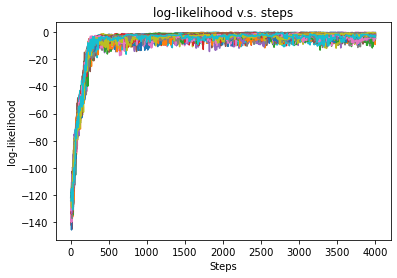

The training time is 20.177576541900635
The test accuracy is 0.9736842105263158


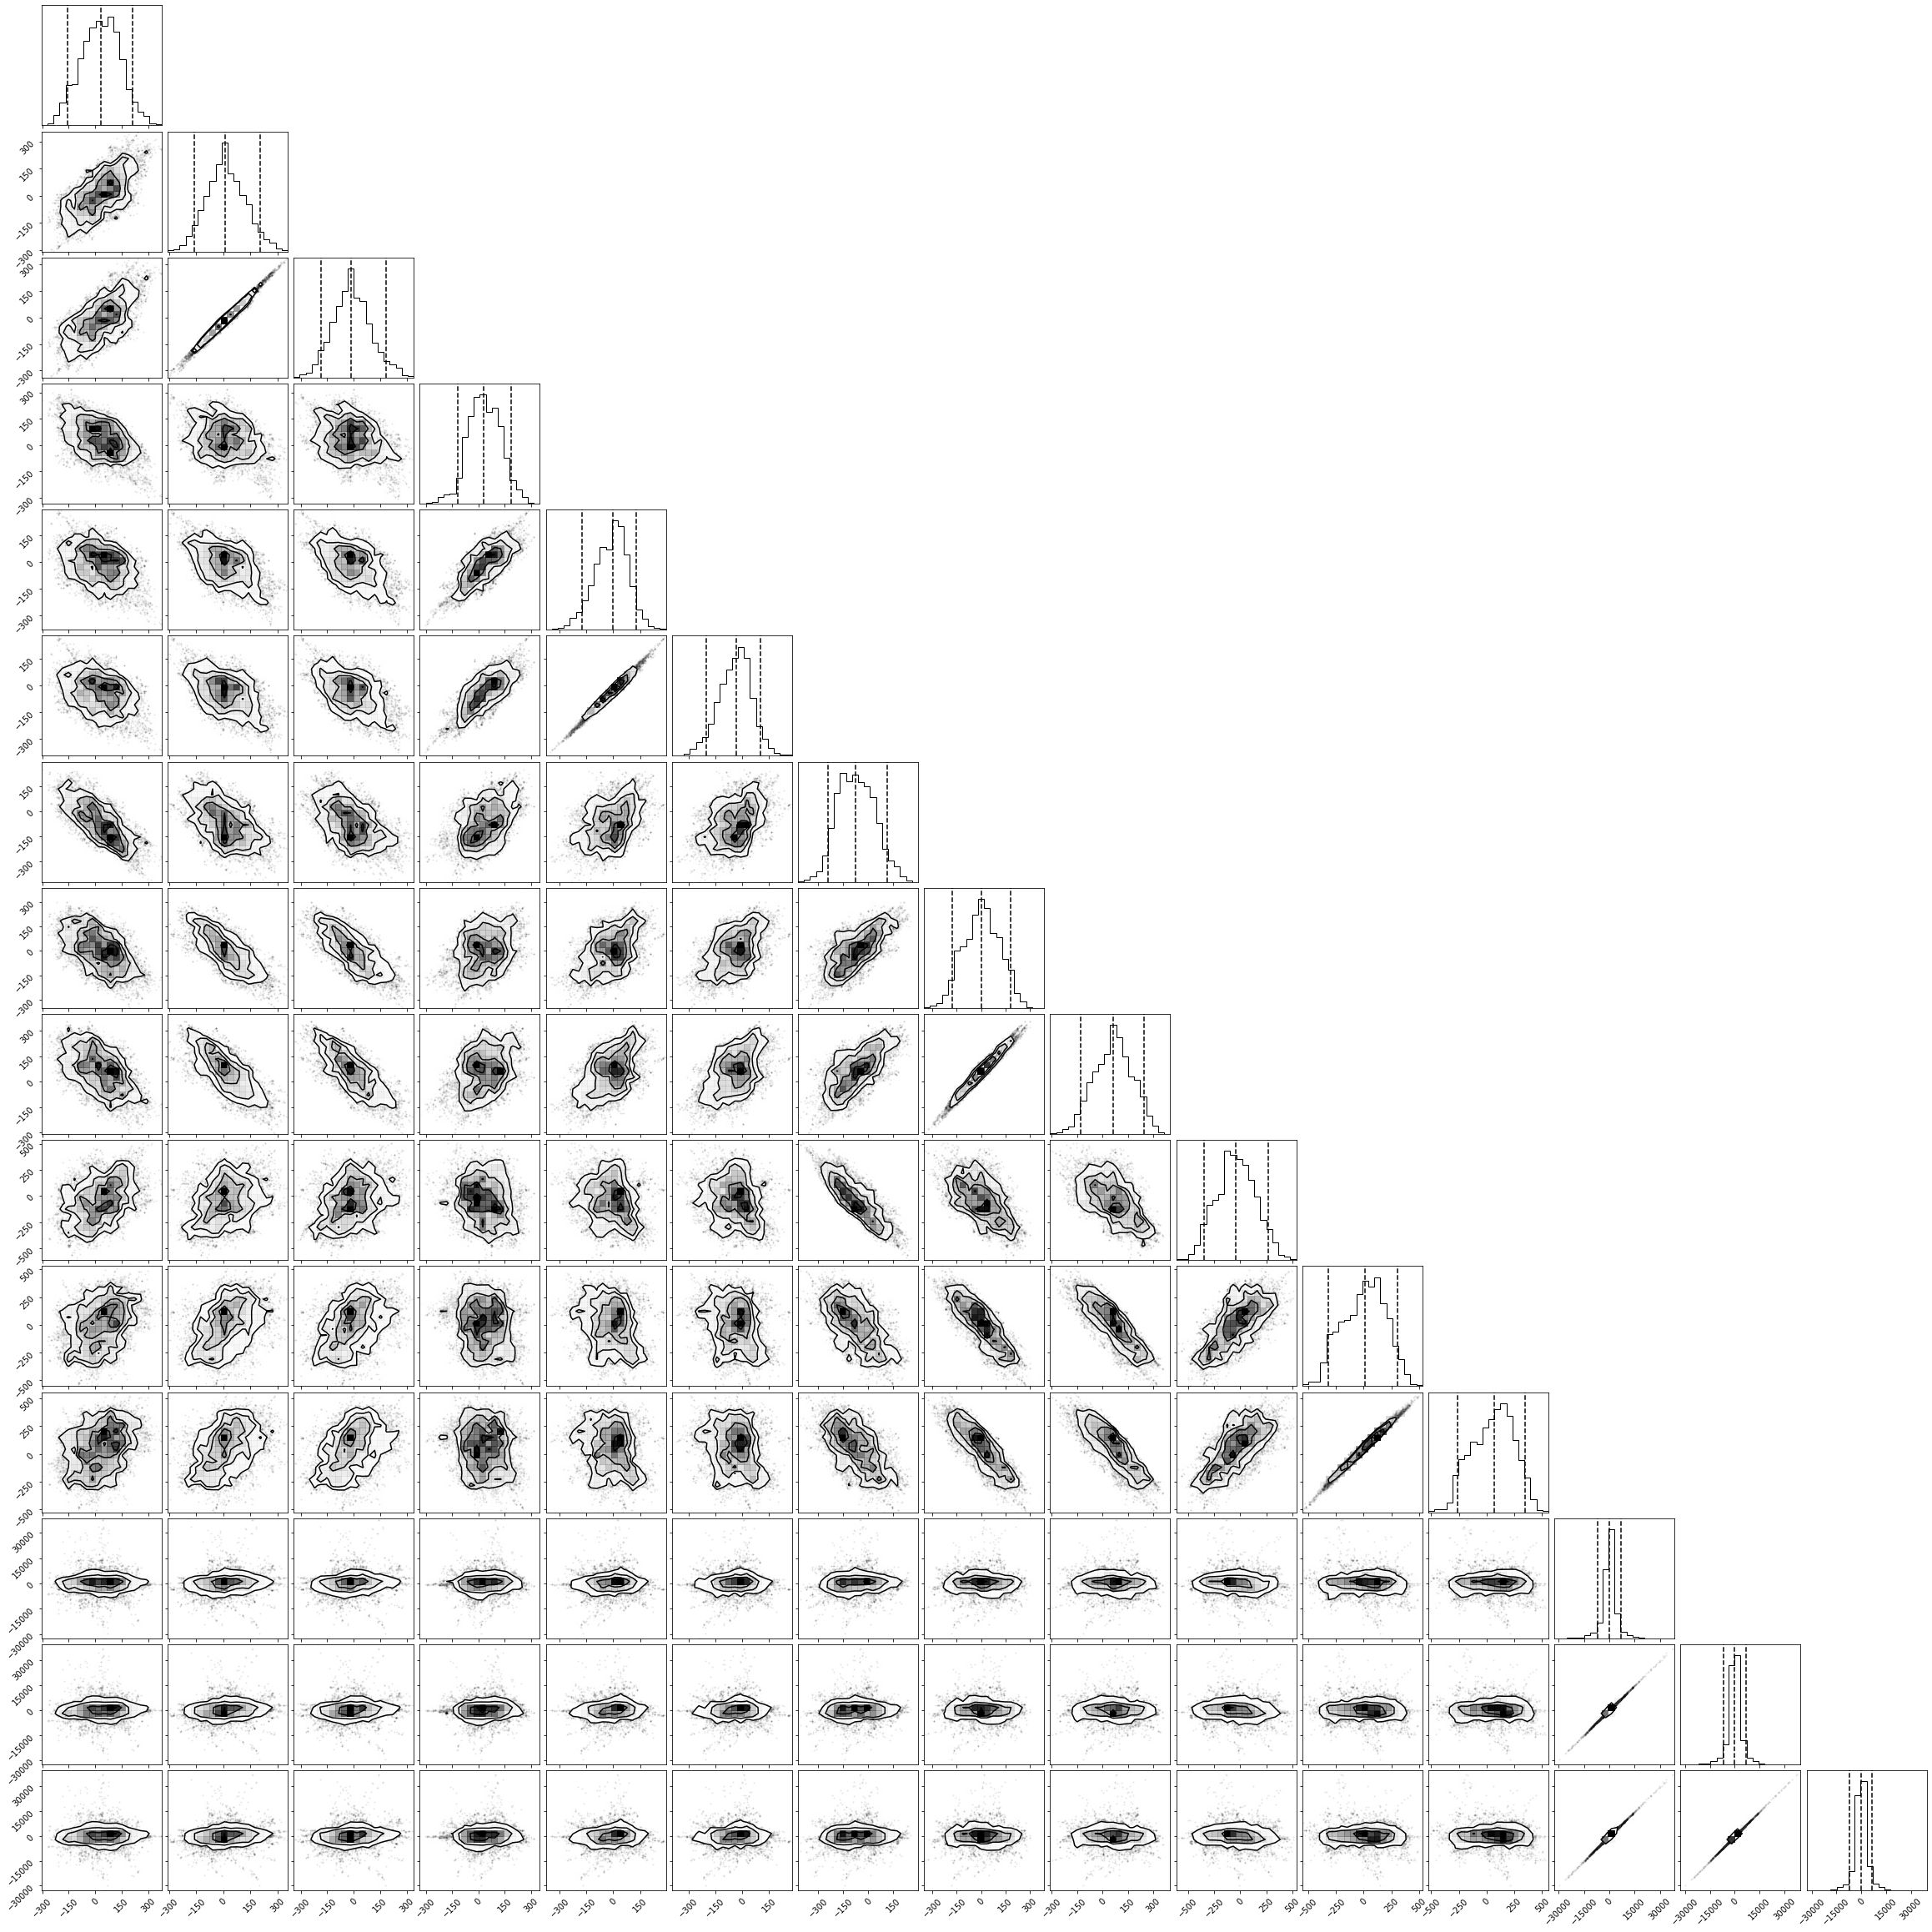

In [9]:
start = time.time()
regressor_iris_MC = SoftmaxRegression().fit(train_x,train_y, 
                                            BayesianInferenceMCMC(visual_log_like=True, corner=True))
stop = time.time()
train_time = stop - start
test_yh = regressor_iris_MC.predict(test_x)
test_accuracy = (to_classlabel(test_yh) == test_y).astype(float).mean()
print("The training time is", train_time)
print("The test accuracy is", test_accuracy)

## Performance Analysis 2: SDSS dataset

In [10]:
# read the raw SDSS dataset
SDSS = pd.read_csv('Skyserver_SQL2_27_2018 6_51_39 PM.csv')
# drop the irrelevant data:
SDSS.drop(['objid', 'rerun', 'specobjid', 'plate'], axis=1, inplace=True)
# drop the correlated data:
SDSS.drop(['g', 'r', 'i', 'mjd'], axis=1, inplace=True)
# rearrange the columns
SDSS = SDSS[['ra', 'dec', 'u', 'z', 'run', 'camcol', 'field', 'redshift', 'fiberid', 'class']]
# convert the labels to 0,1,2 for easy one-hot encoding
SDSS['class'] = SDSS['class'].replace(['STAR'], 0)
SDSS['class'] = SDSS['class'].replace(['GALAXY'], 1)
SDSS['class'] = SDSS['class'].replace(['QSO'], 2)
# convert the pd dataframe into a np array for use
SDSS_data = SDSS.values

train = SDSS_data[:(len(SDSS_data)*3//4)]
train_x = train[:,:-1]
train_y = train[:,-1].astype(int)

test = SDSS_data[(len(SDSS_data)*3//4):]
test_x = test[:,:-1]
test_y = test[:,-1].astype(int)

In [12]:
start = time.time()
regressor_SDSS_GD = SoftmaxRegression().fit(train_x,train_y, 
                                            ImprovedGradientDescent(learning_rate=0.001,momentum=0.9, batch_size=1))
stop = time.time()
train_time = stop - start
test_yh = regressor_SDSS_GD.predict(test_x)
test_accuracy = (to_classlabel(test_yh) == test_y).astype(float).mean()
print("The training time is", train_time)
print("The test accuracy is", test_accuracy)

The training time is 18.21427583694458
The test accuracy is 0.5212


In [13]:
start = time.time()
regressor_SDSS_MC = SoftmaxRegression().fit(train_x,train_y, 
                                            BayesianInferenceMCMC())
stop = time.time()
train_time = stop - start
test_yh = regressor_SDSS_MC.predict(test_x)
test_accuracy = (to_classlabel(test_yh) == test_y).astype(float).mean()
print("The training time is", train_time)
print("The test accuracy is", test_accuracy)

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [04:22<00:00, 15.25it/s]


The training time is 262.53670144081116
The test accuracy is 0.6696
